In [2]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model
#import statsmodels.formula.api as smf
import statsmodels.api as sm
import directional # from https://github.com/calben/directionalstatspy/
from IPython.display import display

In [3]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file) for file in csv_files])
df_imported = df_imported.rename(columns={'Unnamed: 0': 'record_time'})
df_imported = df_imported.drop_duplicates(subset='record_time', keep='last')
df_imported = df_imported.set_index('record_time')
df_imported.count()

$                           200
dateStamp                    30
dew_point                   200
modelCode                    30
modelRun                     30
periodSchedule               30
pressure                    200
screen_relative_humidity    200
sea_temperature             200
surf_max                     30
surf_min                     30
swell_direction1             30
swell_direction2             30
swell_direction3             30
swell_height1                30
swell_height2                30
swell_height3                30
swell_period1                30
swell_period2                30
swell_period3                30
temperature                 200
wave_height                 200
wave_period                 200
wind_direction              200
wind_speed                  200
dtype: int64

available target values: 30


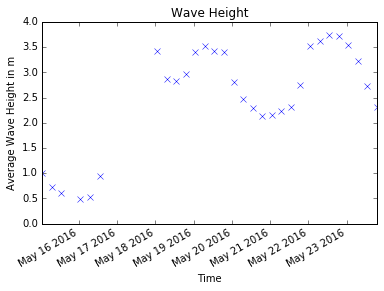

target values after interpolation: 191


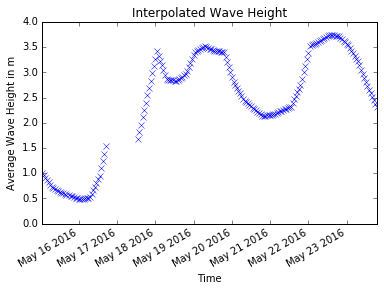

In [10]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', 'bx')
# fill NAs with linearly interpolated data
# TODO: Only for points which are max. 5h apart
s_target = s_target.interpolate()
print('target values after interpolation:', s_target.count())
def plot_datetime_series(series, title, xlabel='Time', ylabel='', label=['b-', 'g-', 'r-', 'y-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        plt.plot_date(
            matplotlib.dates.date2num(
                [dateutil.parser.parse(dt) for dt in s.index]
            ), 
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()
    

plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', 'bx')

In [6]:
#directional.angle.radian_matrix_to_sin_cos_matrix(pd.DataFrame(df_explanatory['wind_direction']))?circular_example.drop
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees--SIN,degrees--COS
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


In [7]:
df_explanatory = df_imported[['wind_direction','dew_point', 'screen_relative_humidity', 'pressure', 'wind_speed', 'sea_temperature', 'temperature', 'wave_height', 'wave_period']]
df_explanatory = df_explanatory.dropna()
df_explanatory
display(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('becomes')
display(df_explanatory['wind_direction'].head())
print('becomes')
df_explanatory = degrees_to_sin_cos(df_explanatory, 'wind_direction')
display(df_explanatory.head())

record_time
2016-05-14T16:00:00+00:00     NW
2016-05-14T17:00:00+00:00    NNW
2016-05-14T18:00:00+00:00     NW
2016-05-14T19:00:00+00:00     NW
2016-05-14T20:00:00+00:00    WNW
Name: wind_direction, dtype: object

becomes


record_time
2016-05-14T16:00:00+00:00    315.0
2016-05-14T17:00:00+00:00    337.5
2016-05-14T18:00:00+00:00    315.0
2016-05-14T19:00:00+00:00    315.0
2016-05-14T20:00:00+00:00    292.5
Name: wind_direction, dtype: float64

becomes


,dew_point,screen_relative_humidity,pressure,wind_speed,sea_temperature,temperature,wave_height,wave_period,wind_direction--SIN,wind_direction--COS
record_time,,,,,,,,,,
2016-05-14T16:00:00+00:00,10.7,92.3,1023,4,12.7,11.9,1.1,6,-0.707107,0.707107
2016-05-14T17:00:00+00:00,10.8,91.6,1023,6,12.7,12.1,1.2,6,-0.382683,0.923880
2016-05-14T18:00:00+00:00,10.6,91.7,1023,5,12.9,11.9,1.0,5,-0.707107,0.707107
2016-05-14T19:00:00+00:00,10.5,91.6,1024,7,12.8,11.8,1.1,5,-0.707107,0.707107
2016-05-14T20:00:00+00:00,10.3,92.3,1024,7,12.8,11.5,1.1,6,-0.923880,0.382683


In [11]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
float64,dew_point
float64,screen_relative_humidity
int64,pressure
int64,wind_speed
float64,sea_temperature
float64,temperature
float64,wave_height
float64,wave_period
float64,wind_direction--SIN
float64,wind_direction--COS


In [12]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

dew_point                   191
screen_relative_humidity    191
pressure                    191
wind_speed                  191
sea_temperature             191
temperature                 191
wave_height                 191
wave_period                 191
wind_direction--SIN         191
wind_direction--COS         191
surf_avg                    191
dtype: int64

                              live
dew_point                -0.320478
screen_relative_humidity -0.440809
pressure                 -0.433713
wind_speed                0.528470
sea_temperature           0.489655
temperature               0.059388
wave_height               0.766675
wave_period               0.043728
wind_direction--SIN      -0.163931
wind_direction--COS       0.339743


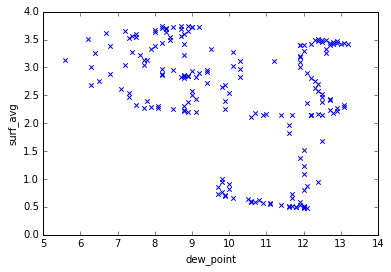

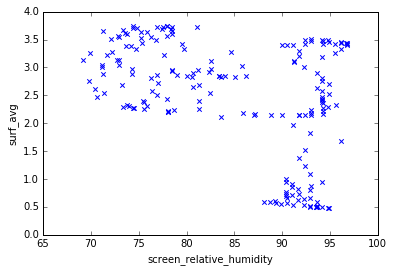

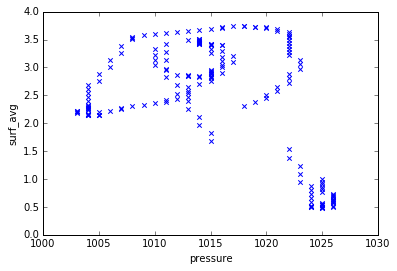

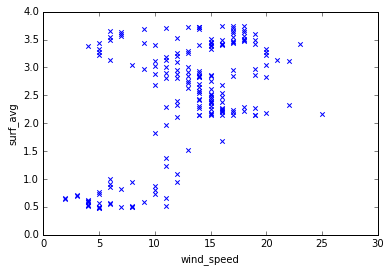

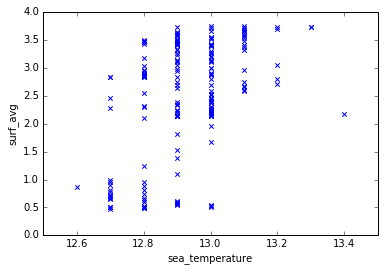

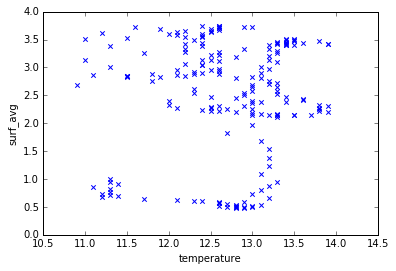

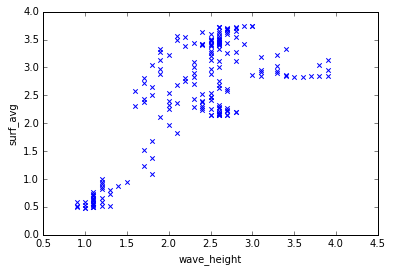

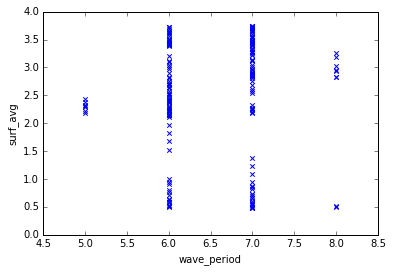

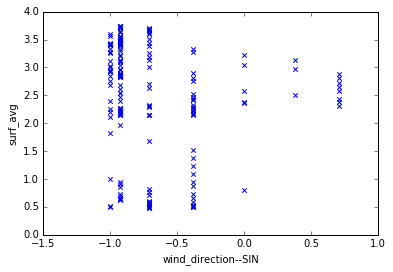

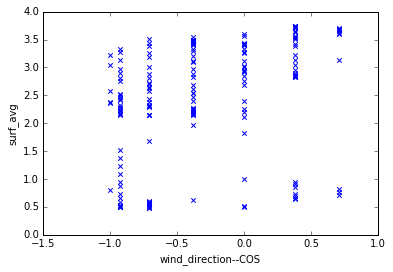

In [13]:
target_correlations = pd.Series([df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns])
target_correlations.name = 'live'
target_correlations = pd.DataFrame(target_correlations)
target_correlations.index = df_explanatory.columns
print(target_correlations)
#fix, axes =plt.subplots(nrows=len(df_explanatory.columns), figsize=(8,8))
for column in df_explanatory.columns:
    df_train.plot.scatter(x=column, y=target_var, marker='x')

In [14]:
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,23):
    target_correlations['ewma'+str(span)] = pd.Series([ pd.ewma(df_train[column], span=span).corr(df_train[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
target_correlations
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,live,ewma2,ewma3,ewma4,ewma5,ewma6,ewma7,ewma8,ewma9,ewma10,...,ewma13,ewma14,ewma15,ewma16,ewma17,ewma18,ewma19,ewma20,ewma21,ewma22
dew_point,-0.320478,-0.324156,-0.327305,-0.330388,-0.333482,-0.336615,-0.339787,-0.342973,-0.346137,-0.349234,...,-0.357715,-0.360163,-0.362383,-0.364364,-0.366097,-0.367580,-0.368816,-0.369809,-0.370566,-0.371097
screen_relative_humidity,-0.440809,-0.450086,-0.457956,-0.465402,-0.472592,-0.479609,-0.486494,-0.493259,-0.499891,-0.506366,...,-0.524569,-0.530149,-0.535459,-0.540491,-0.545242,-0.549715,-0.553915,-0.557849,-0.561528,-0.564963
pressure,-0.433713,-0.445672,-0.457403,-0.469015,-0.480514,-0.491896,-0.503157,-0.514285,-0.525261,-0.536061,...,-0.567114,-0.576922,-0.586420,-0.595588,-0.604413,-0.612885,-0.620998,-0.628750,-0.636144,-0.643182
wind_speed,0.528470,0.553315,0.570521,0.586001,0.600798,0.615137,0.629026,0.642418,0.655261,0.667514,...,0.700521,0.710264,0.719396,0.727933,0.735900,0.743322,0.750224,0.756636,0.762584,0.768097
sea_temperature,0.489655,0.530431,0.549692,0.561804,0.570373,0.576751,0.581608,0.585361,0.588305,0.590665,...,0.595730,0.597064,0.598317,0.599522,0.600700,0.601865,0.603024,0.604182,0.605341,0.606499
temperature,0.059388,0.067359,0.074724,0.082064,0.089441,0.096832,0.104219,0.111596,0.118970,0.126353,...,0.148669,0.156193,0.163765,0.171387,0.179053,0.186760,0.194500,0.202265,0.210044,0.217830
wave_height,0.766675,0.776653,0.784190,0.791213,0.798025,0.804666,0.811109,0.817313,0.823234,0.828832,...,0.843441,0.847536,0.851240,0.854558,0.857502,0.860085,0.862324,0.864239,0.865850,0.867177
wave_period,0.043728,0.056069,0.066271,0.075869,0.085450,0.095224,0.105203,0.115298,0.125378,0.135306,...,0.163069,0.171392,0.179178,0.186411,0.193087,0.199217,0.204816,0.209907,0.214518,0.218676
wind_direction--SIN,-0.163931,-0.175458,-0.184648,-0.192763,-0.200100,-0.206771,-0.212848,-0.218385,-0.223425,-0.228004,...,-0.239209,-0.242157,-0.244734,-0.246952,-0.248823,-0.250361,-0.251577,-0.252486,-0.253103,-0.253442
wind_direction--COS,0.339743,0.348294,0.350800,0.350837,0.349299,0.346609,0.343031,0.338745,0.333873,0.328505,...,0.309984,0.303135,0.295998,0.288597,0.280957,0.273100,0.265048,0.256823,0.248447,0.239941


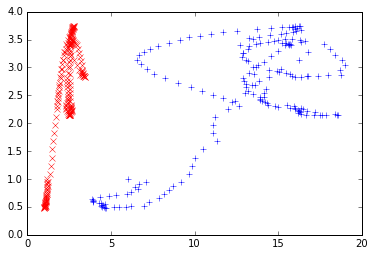

In [15]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], 'b+')
plt.plot(pd.ewma(df_train['wave_height'], span=12), df_train[target_var], 'rx')

In [16]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [-3.71350827  0.62608454  0.05054767 -0.00499796  1.83400695  4.01581
  1.18505449 -0.22676437 -0.1075711   0.35120608]


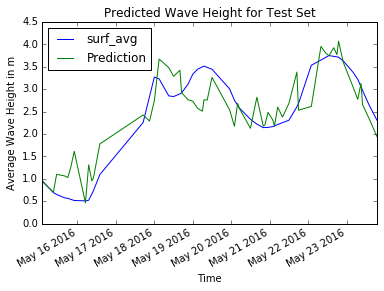

In [17]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m')

coefficients:  [-10.21319211   1.74213018   0.09960842   0.05955255   0.70510912
  10.73763509   1.07527739  -0.30221836  -0.8869358    0.26855285]
intercept:  -289.756913497


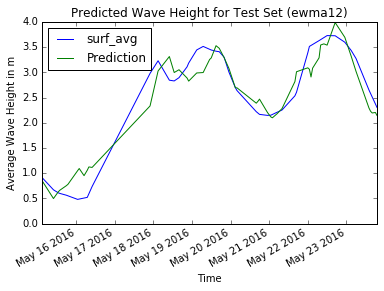

In [19]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_ewma12, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set (ewma12)', 'Time', 'Average Wave Height in m')

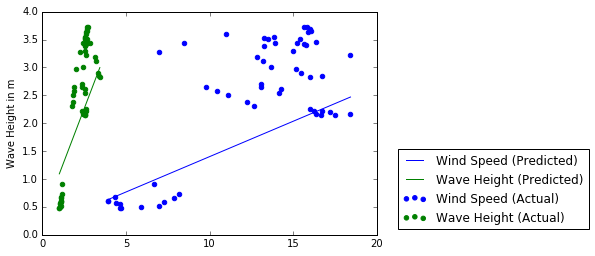

In [20]:
plt.scatter(
    test_set['wind_speed'],
    test_set[target_var],
    color='b'
)
plt.scatter(
    test_set['wave_height'],
    test_set[target_var],
    color='g'
)

predictions_wind_speed = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wind_speed'], name='Prediction').sort_index()
predictions_wave_height = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wave_height'], name='Prediction').sort_index()

plt.plot([test_set['wind_speed'].min(), test_set['wind_speed'].max()], [predictions_wind_speed.iloc[0], predictions_wind_speed.iloc[-1]])
plt.plot([test_set['wave_height'].min(), test_set['wave_height'].max()], [predictions_wave_height.iloc[0], predictions_wave_height.iloc[-1]])
plt.legend(['Wind Speed (Predicted)', 'Wave Height (Predicted)', 'Wind Speed (Actual)', 'Wave Height (Actual)'], bbox_to_anchor=(1.65, 0), loc='lower right')
plt.ylabel('Wave Height in m')

In [21]:
lm = sm.OLS(train_set[target_var], train_set[df_explanatory.columns]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     535.7
Date:                Tue, 24 May 2016   Prob (F-statistic):           6.33e-97
Time:                        20:16:57   Log-Likelihood:                -68.375
No. Observations:                 134   AIC:                             156.7
Df Residuals:                     124   BIC:                             185.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
dew_point                    0.2042      0.998      0.205      0.838        -1.770     2.179
screen_relative_humidity    -0.0895      0.168     -0.533      0.595        -0.422     0.243
pressure                    -0.0115      0.013     -0.921      0.359        -0.036     0.013
wind_speed                  -0.0233      0.033     -0.699      0.486        -0.089     0.043
sea_temperature              0.4911      1.127      0.436      0.664        -1.739     2.721
temperature                  0.9288      1.211      0.767      0.444        -1.468     3.325
wave_height                  0.6135      0.184      3.341      0.001         0.250     0.977
wave_period                  0.1539      0.204      0.753      0.453        -0.251     0.559
wind_direction--SIN          0.1562      0.300      0.520      0.604        -0.438     0.751
wind_direction--COS          1.1852      0.296      4.004      0.000         0.599     1.771
==============================================================================
Omnibus:                       22.767   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.098
Skew:                          -0.112   Prob(JB):                       0.0474
Kurtosis:                       1.979   Cond. No.                     5.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R² value indicates the percentage of variance in the data which are explained by the model. This is a good fit, but also may indicate overfit.

In [22]:
print('p value >= 0.5')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.5')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.5
dew_point                   0.838179
screen_relative_humidity    0.595147
pressure                    0.358785
wind_speed                  0.485862
sea_temperature             0.663729
temperature                 0.444472
wave_period                 0.452981
wind_direction--SIN         0.604072
dtype: float64

p value < 0.5
wave_height            0.001102
wind_direction--COS    0.000107
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.